In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D,Conv1DTranspose,Concatenate,Input
import numpy as np
import IPython.display
import glob
from tqdm.notebook import tqdm
import librosa.display
import matplotlib.pyplot as plt

In [5]:
#!mkdir "CleanData"
#!mkdir "NoisyData"


In [6]:
clean_sounds = glob.glob('CleanData/*')
noisy_sounds = glob.glob('NoisyData/*')

clean_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(clean_sounds[0]),desired_channels=1)
for i in tqdm(clean_sounds[1:]):
  so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
  clean_sounds_list = tf.concat((clean_sounds_list,so),0)

noisy_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(noisy_sounds[0]),desired_channels=1)
for i in tqdm(noisy_sounds[1:]):
  so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
  noisy_sounds_list = tf.concat((noisy_sounds_list,so),0)

clean_sounds_list.shape,noisy_sounds_list.shape

  0%|          | 0/11571 [00:00<?, ?it/s]

  0%|          | 0/11571 [00:00<?, ?it/s]

(TensorShape([1622804651, 1]), TensorShape([1622804651, 1]))

In [13]:
batching_size = 12000

clean_train,noisy_train = [],[]

for i in tqdm(range(0,clean_sounds_list.shape[0]-batching_size,batching_size)):
  clean_train.append(clean_sounds_list[i:i+batching_size])
  noisy_train.append(noisy_sounds_list[i:i+batching_size])

clean_train = tf.stack(clean_train)
noisy_train = tf.stack(noisy_train)

clean_train.shape,noisy_train.shape

  0%|          | 0/135233 [00:00<?, ?it/s]

(TensorShape([135233, 12000, 1]), TensorShape([135233, 12000, 1]))

In [489]:
def get_dataset(x_train,y_train):
  dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
  dataset = dataset.shuffle(100).batch(64,drop_remainder=True)
  return dataset

In [491]:
train_dataset = get_dataset(noisy_train[:40000],clean_train[:40000])
test_dataset = get_dataset(noisy_train[40000:],clean_train[40000:])

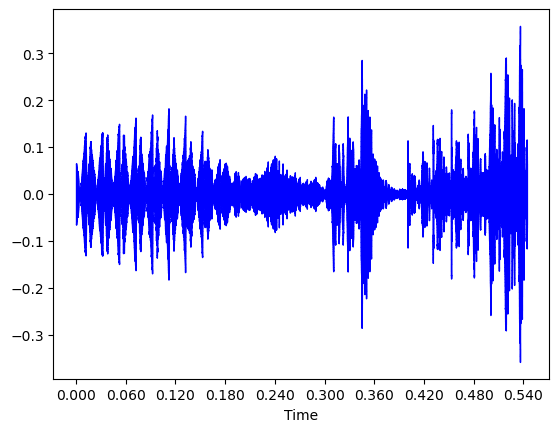

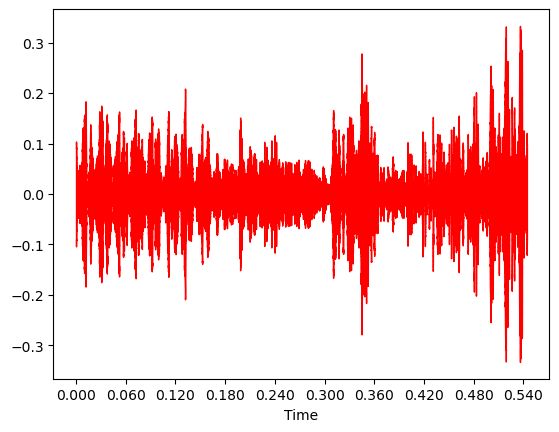

In [493]:
clean_color = 'blue'
noisy_color = 'red'

# Display clean waveform
librosa.display.waveshow(np.squeeze(clean_train[5].numpy(), axis=-1), color=clean_color)
plt.show()

# Display noisy waveform
librosa.display.waveshow(np.squeeze(noisy_train[5].numpy(), axis=-1), color=noisy_color)
plt.show()

In [495]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Conv1DTranspose, GlobalAveragePooling1D, Dense, Reshape, Multiply, Concatenate
from tensorflow.keras.models import Model

def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    shared_layer_one = Dense(channel//ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
   
    avg_pool = GlobalAveragePooling1D()(input_feature)    
    avg_pool = Reshape((1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
   
    max_pool = tf.reduce_max(input_feature, axis=1, keepdims=True)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
   
    scale = tf.sigmoid(avg_pool + max_pool)
    scale = Reshape((1, channel))(scale)
   
    return Multiply()([input_feature, scale])

# Define the model with attention
inp = Input(shape=(None, 1))
c1 = Conv1D(2, 32, 2, padding='same', activation='relu')(inp)
a1 = channel_attention(c1)
c2 = Conv1D(4, 32, 2, padding='same', activation='relu')(a1)
a2 = channel_attention(c2)
c3 = Conv1D(8, 32, 2, padding='same', activation='relu')(a2)
a3 = channel_attention(c3)
c4 = Conv1D(16, 32, 2, padding='same', activation='relu')(a3)
a4 = channel_attention(c4)
c5 = Conv1D(32, 32, 2, padding='same', activation='relu')(a4)
a5 = channel_attention(c5)
c6 = Conv1D(64, 32, 2, padding='same', activation='relu')(a5)
c7 = Conv1D(128, 32, 2, padding='same', activation='relu')(c6)

# Transposed Convolution Layers with Concatenation
dc1 = Conv1DTranspose(128, 32, 1, padding='same')(c7)
conc = Concatenate()([c7, dc1])
dc2 = Conv1DTranspose(64, 32, 2, padding='same')(conc)
conc = Concatenate()([c6, dc2])
dc3 = Conv1DTranspose(32, 32, 2, padding='same', output_padding=1)(conc)
conc = Concatenate()([a5, dc3])
dc4 = Conv1DTranspose(16, 32, 2, padding='same')(conc)
conc = Concatenate()([a4, dc4])
dc5 = Conv1DTranspose(8, 32, 2, padding='same')(conc)
conc = Concatenate()([a3, dc5])
dc6 = Conv1DTranspose(4, 32, 2, padding='same')(conc)
conc = Concatenate()([a2, dc6])
dc7 = Conv1DTranspose(2, 32, 2, padding='same')(conc)
conc = Concatenate()([a1, dc7])
dc8 = Conv1DTranspose(1, 32, 2, padding='same')(conc)
conc = Concatenate()([inp, dc8])
dc9 = Conv1DTranspose(1, 32, 1, padding='same', activation='linear')(conc)
model = Model(inputs=inp, outputs=dc9)
model.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, None, 1)]    0           []                               
                                                                                                  
 conv1d_81 (Conv1D)             (None, None, 2)      66          ['input_13[0][0]']               
                                                                                                  
 global_average_pooling1d_15 (G  (None, 2)           0           ['conv1d_81[0][0]']              
 lobalAveragePooling1D)                                                                           
                                                                                                  
 reshape_30 (Reshape)           (None, 1, 2)         0           ['global_average_pooling1d_

In [497]:
'''# Previous layers as defined
inp = Input(shape=(batching_size, 1))
c1 = Conv1D(2, 32, 2, 'same', activation='relu')(inp)
c2 = Conv1D(4, 32, 2, 'same', activation='relu')(c1)
c3 = Conv1D(8, 32, 2, 'same', activation='relu')(c2)
c4 = Conv1D(16, 32, 2, 'same', activation='relu')(c3)
c5 = Conv1D(32, 32, 2, 'same', activation='relu')(c4)

# New layers added
c6 = Conv1D(64, 32, 2, 'same', activation='relu')(c5)
c7 = Conv1D(128, 32, 2, 'same', activation='relu')(c6)

# Modify the first deconvolutional connection
dc1 = Conv1DTranspose(128, 32, 1, padding='same')(c7)
conc = Concatenate()([c7, dc1])

# Adjust the following layers to match the new connection scheme
dc2 = Conv1DTranspose(64, 32, 2, padding='same')(conc)
conc = Concatenate()([c6, dc2])
dc3 = Conv1DTranspose(32, 32, 2, padding='same',output_padding=1)(conc)
conc = Concatenate()([c5, dc3])
dc4 = Conv1DTranspose(16, 32, 2, padding='same')(conc)
conc = Concatenate()([c4, dc4]) 
dc5 = Conv1DTranspose(8, 32, 2, padding='same')(conc)
conc = Concatenate()([c3, dc5])
dc6 = Conv1DTranspose(4, 32, 2, padding='same')(conc)
conc = Concatenate()([c2, dc6])
dc7 = Conv1DTranspose(2, 32, 2, padding='same')(conc)
conc = Concatenate()([c1, dc7])
dc8 = Conv1DTranspose(1, 32, 2, padding='same')(conc)
conc = Concatenate()([inp, dc8])
dc9 = Conv1DTranspose(1, 32, 1, padding='same', activation='linear')(conc)



# Finalize the model
model = tf.keras.models.Model(inputs=inp, outputs=dc9)
model.summary()'''


"# Previous layers as defined\ninp = Input(shape=(batching_size, 1))\nc1 = Conv1D(2, 32, 2, 'same', activation='relu')(inp)\nc2 = Conv1D(4, 32, 2, 'same', activation='relu')(c1)\nc3 = Conv1D(8, 32, 2, 'same', activation='relu')(c2)\nc4 = Conv1D(16, 32, 2, 'same', activation='relu')(c3)\nc5 = Conv1D(32, 32, 2, 'same', activation='relu')(c4)\n\n# New layers added\nc6 = Conv1D(64, 32, 2, 'same', activation='relu')(c5)\nc7 = Conv1D(128, 32, 2, 'same', activation='relu')(c6)\n\n# Modify the first deconvolutional connection\ndc1 = Conv1DTranspose(128, 32, 1, padding='same')(c7)\nconc = Concatenate()([c7, dc1])\n\n# Adjust the following layers to match the new connection scheme\ndc2 = Conv1DTranspose(64, 32, 2, padding='same')(conc)\nconc = Concatenate()([c6, dc2])\ndc3 = Conv1DTranspose(32, 32, 2, padding='same',output_padding=1)(conc)\nconc = Concatenate()([c5, dc3])\ndc4 = Conv1DTranspose(16, 32, 2, padding='same')(conc)\nconc = Concatenate()([c4, dc4]) \ndc5 = Conv1DTranspose(8, 32, 2, pa

In [499]:
!pip install --upgrade pip


!pip install pydot
!pip install pydot graphviz
!pip install --upgrade pydot graphviz
import pandas as pd  # Importing pandas
from tensorflow.keras.utils import plot_model
import os

# Assuming '/opt/homebrew/bin' is where 'dot' is located, update accordingly
path = os.environ['PATH']
if '/opt/homebrew/bin' not in path:
    os.environ['PATH'] += ':/opt/homebrew/bin'

# Verify if dot is now accessible
!dot -V

plot_model(model, to_file='modelattentionlayers.png', show_shapes=True, show_layer_names=True, rankdir='TB', dpi=300)


layers = [(layer.__class__.__name__, layer.output_shape, layer.count_params()) for layer in model.layers]
df = pd.DataFrame(layers, columns=['Layer Type', 'Output Shape', 'Param #'])
print(df)

python(22177) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(22178) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(22179) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(22180) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


dot - graphviz version 11.0.0 (20240428.1522)


python(22181) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22182) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22183) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


                Layer Type       Output Shape  Param #
0               InputLayer  [(None, None, 1)]        0
1                   Conv1D    (None, None, 2)       66
2   GlobalAveragePooling1D          (None, 2)        0
3                  Reshape       (None, 1, 2)        0
4               TFOpLambda       (None, 1, 2)        0
..                     ...                ...      ...
65         Conv1DTranspose    (None, None, 2)      514
66             Concatenate    (None, None, 4)        0
67         Conv1DTranspose    (None, None, 1)      129
68             Concatenate    (None, None, 2)        0
69         Conv1DTranspose    (None, None, 1)       65

[70 rows x 3 columns]


python(22185) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22186) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


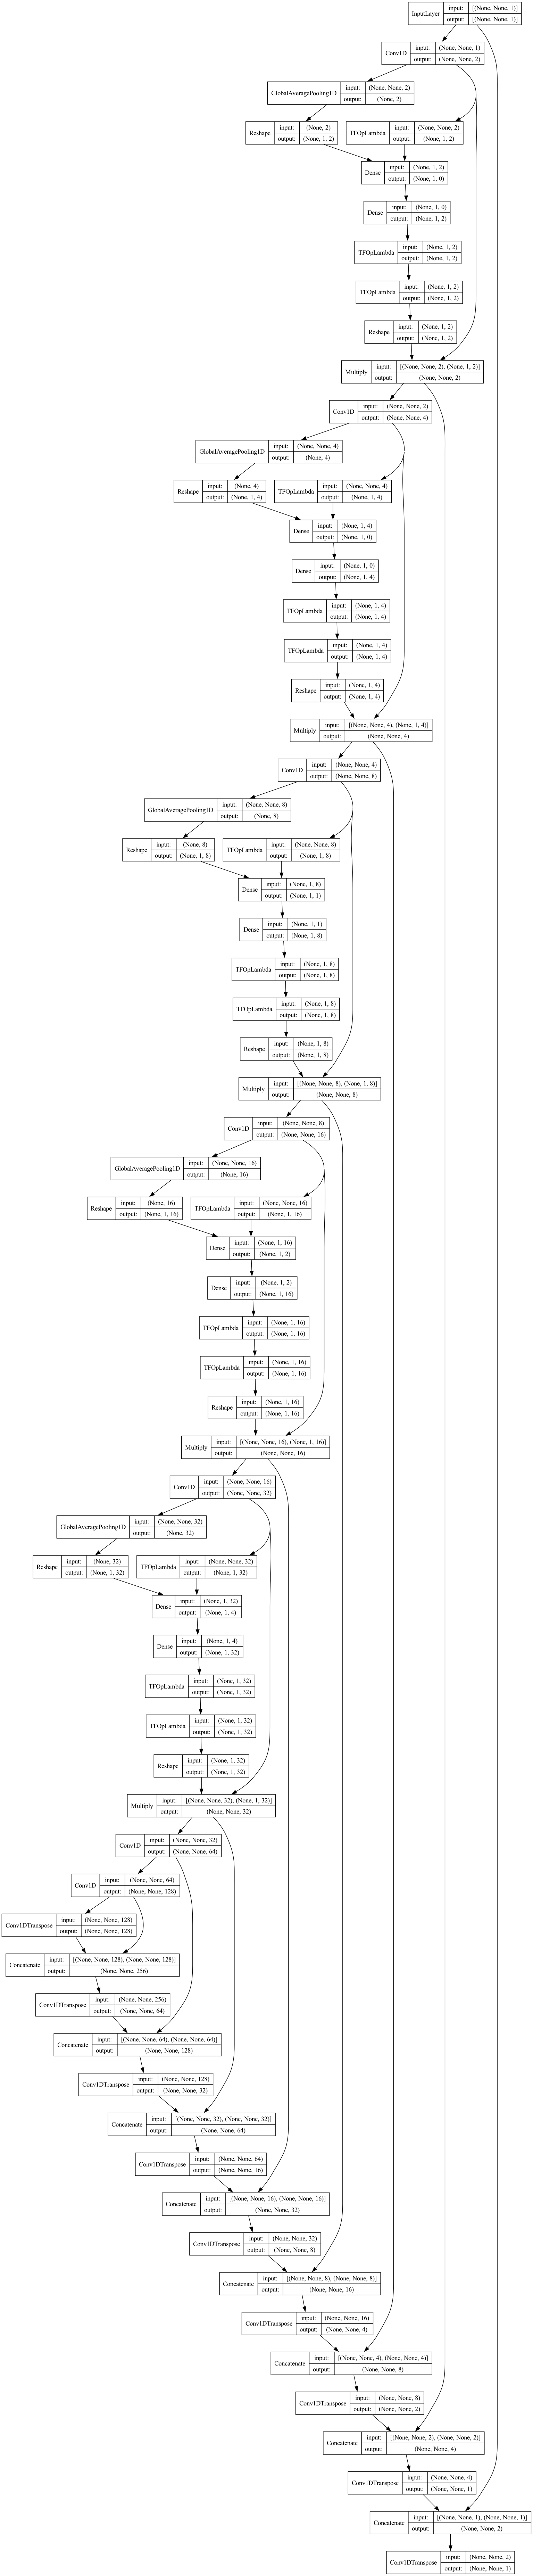

In [501]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=False)

In [503]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.002),loss=tf.keras.losses.MeanAbsoluteError(), metrics=['mean_squared_error'])
history = model.fit(train_dataset,epochs=20)

2024-05-07 12:58:34.494421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [40000,12000,1]
	 [[{{node Placeholder/_1}}]]
2024-05-07 12:58:34.497486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [40000,12000,1]
	 [[{{node Placeholder/_1}}]]


Epoch 1/20
625/625 [==============================] - 238s 380ms/step - loss: 0.0185 - mean_squared_error: 8.9485e-04
Epoch 2/20
625/625 [==============================] - 232s 371ms/step - loss: 0.0157 - mean_squared_error: 6.7317e-04
Epoch 3/20
625/625 [==============================] - 231s 370ms/step - loss: 0.0359 - mean_squared_error: 0.0466
Epoch 4/20
625/625 [==============================] - 226s 362ms/step - loss: 0.0169 - mean_squared_error: 7.5026e-04
Epoch 5/20
625/625 [==============================] - 229s 367ms/step - loss: 0.0164 - mean_squared_error: 7.1450e-04
Epoch 6/20
625/625 [==============================] - 229s 366ms/step - loss: 0.0152 - mean_squared_error: 6.2261e-04
Epoch 7/20
625/625 [==============================] - 230s 368ms/step - loss: 0.0142 - mean_squared_error: 5.4939e-04
Epoch 8/20
625/625 [==============================] - 230s 368ms/step - loss: 0.0138 - mean_squared_error: 5.2720e-04
Epoch 9/20
625/625 [==============================] - 231s 3

In [505]:
from IPython.display import Audio
Audio(np.squeeze(noisy_train[22].numpy()),rate=48000)

In [507]:
Audio(tf.squeeze(model.predict(tf.expand_dims(tf.expand_dims(noisy_train[22],-1),0))),rate=48000)

1/1 [==============================] - 0s 378ms/step


In [509]:
model.evaluate(test_dataset)

2024-05-07 14:42:07.456965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [95233,12000,1]
	 [[{{node Placeholder/_1}}]]
2024-05-07 14:42:07.457476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [95233,12000,1]
	 [[{{node Placeholder/_1}}]]


1488/1488 [==============================] - 217s 143ms/step - loss: 0.0126 - mean_squared_error: 4.5157e-04


[0.012568133883178234, 0.000451568077551201]

In [511]:


# Custom metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Compile the model with multiple metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.002),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=[
        'mean_squared_error', 
        rmse, 
        'mean_absolute_percentage_error',
        'cosine_similarity',
        'logcosh'
    ]
)

# Fit the model (not shown here)

# Evaluate the model on the test dataset
results = model.evaluate(test_dataset, verbose=2)

# Print each result
print(f"Test Loss: {results[0]}")
print(f"Test MSE: {results[1]}")
print(f"Test RMSE: {results[2]}")
print(f"Test MAPE: {results[3]}")
print(f"Test Cosine Similarity: {results[4]}")
print(f"Test LogCosh Error: {results[5]}")



1488/1488 - 215s - loss: 0.0126 - mean_squared_error: 4.5157e-04 - rmse: 0.0209 - mean_absolute_percentage_error: 17021.0000 - cosine_similarity: 0.4524 - logcosh: 2.2541e-04 - 215s/epoch - 144ms/step
Test Loss: 0.012568086385726929
Test MSE: 0.000451566738775
Test RMSE: 0.020922409370541573
Test MAPE: 17021.0
Test Cosine Similarity: 0.4523547887802124
Test LogCosh Error: 0.00022540598001796752


In [513]:
model.save('NoiseSuppressionModelAttentionLayers.h5')
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, None, 1)]    0           []                               
                                                                                                  
 conv1d_81 (Conv1D)             (None, None, 2)      66          ['input_13[0][0]']               
                                                                                                  
 global_average_pooling1d_15 (G  (None, 2)           0           ['conv1d_81[0][0]']              
 lobalAveragePooling1D)                                                                           
                                                                                                  
 reshape_30 (Reshape)           (None, 1, 2)         0           ['global_average_pooling1d_

Inference

In [516]:
def get_audio(path):
  audio,_ = tf.audio.decode_wav(tf.io.read_file(path),1)
  return audio


In [518]:
def inference_preprocess(path):
  audio = get_audio(path)
  audio_len = audio.shape[0]
  batches = []
  for i in range(0,audio_len-batching_size,batching_size):
    batches.append(audio[i:i+batching_size])

  batches.append(audio[-batching_size:])
  diff = audio_len - (i + batching_size)
  return tf.stack(batches), diff



In [520]:
def predict(path):
    test_data, diff = inference_preprocess(path)
    print("Shape of test_data before prediction:", test_data.shape)  # Debugging line
    predictions = model.predict(test_data)
    print("Shape of predictions:", predictions.shape)  # Debugging line

    final_op = tf.reshape(predictions[:-1], ((predictions.shape[0]-1) * predictions.shape[1], 1))
    final_op = tf.concat([final_op, predictions[-1][-diff:]], axis=0)

    return final_op






In [522]:
Audio(np.squeeze(get_audio(noisy_sounds[4]).numpy(),-1),rate=48000)

In [524]:
#get_audio(noisy_sounds[4]).numpy()
Audio(tf.squeeze(predict(noisy_sounds[4])),rate=48000)


Shape of test_data before prediction: (18, 12000, 1)
1/1 [==============================] - 1s 522ms/step
Shape of predictions: (18, 12000, 1)


In [526]:
%%timeit
tf.squeeze(predict(noisy_sounds[3]))

Shape of test_data before prediction: (8, 12000, 1)
1/1 [==============================] - 0s 41ms/step
Shape of predictions: (8, 12000, 1)
Shape of test_data before prediction: (8, 12000, 1)
1/1 [==============================] - 0s 38ms/step
Shape of predictions: (8, 12000, 1)
Shape of test_data before prediction: (8, 12000, 1)
1/1 [==============================] - 0s 36ms/step
Shape of predictions: (8, 12000, 1)
Shape of test_data before prediction: (8, 12000, 1)
1/1 [==============================] - 0s 36ms/step
Shape of predictions: (8, 12000, 1)
Shape of test_data before prediction: (8, 12000, 1)
1/1 [==============================] - 0s 39ms/step
Shape of predictions: (8, 12000, 1)
Shape of test_data before prediction: (8, 12000, 1)
1/1 [==============================] - 0s 36ms/step
Shape of predictions: (8, 12000, 1)
Shape of test_data before prediction: (8, 12000, 1)
1/1 [==============================] - 0s 46ms/step
Shape of predictions: (8, 12000, 1)
Shape of test_data b

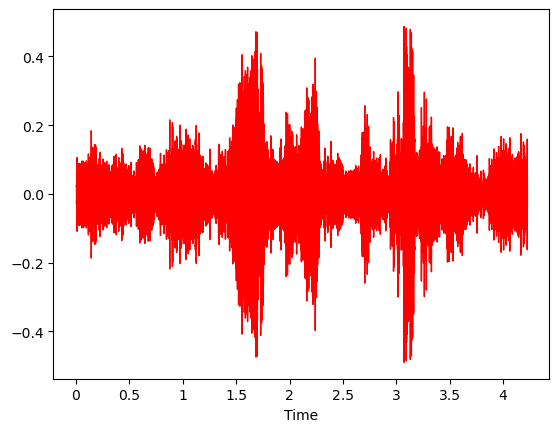

Shape of test_data before prediction: (8, 12000, 1)
1/1 [==============================] - 0s 63ms/step
Shape of predictions: (8, 12000, 1)


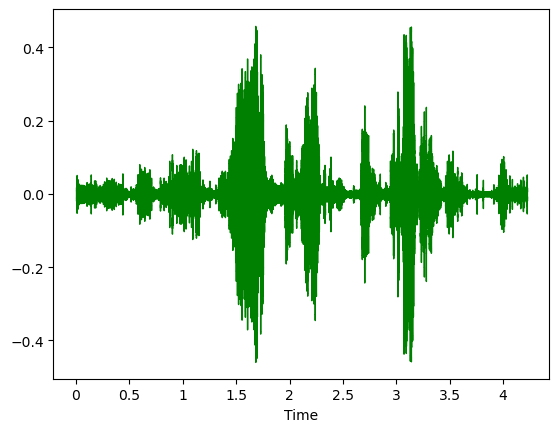

In [548]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Assuming get_audio() and predict() functions are defined elsewhere

# Specify colors for noisy and predicted waveforms
noisy_color = 'red'
predicted_color = 'green'

# Display noisy waveform
librosa.display.waveshow(np.squeeze(get_audio(noisy_sounds[3]).numpy(), axis=-1), color=noisy_color)
plt.show()

# Display predicted waveform
librosa.display.waveshow(np.squeeze(predict(noisy_sounds[3])), color=predicted_color)
plt.show()

In [550]:
lite_model = tf.lite.TFLiteConverter.from_keras_model(model)
lite_model.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quant = lite_model.convert()

2024-05-07 15:20:20.743748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
2024-05-07 15:20:20.754250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,256]
	 [[{{node inputs}}]]
2024-05-07 15:20:20.764848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
2024-05-07

INFO:tensorflow:Assets written to: /var/folders/3g/phb__3hn29s7r3djkr25572h0000gn/T/tmpjq0pdpih/assets


INFO:tensorflow:Assets written to: /var/folders/3g/phb__3hn29s7r3djkr25572h0000gn/T/tmpjq0pdpih/assets
2024-05-07 15:20:26.176132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'serving_default_input_13' with dtype float and shape [?,?,1]
	 [[{{node serving_default_input_13}}]]
2024-05-07 15:20:27.066325: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-05-07 15:20:27.066344: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-05-07 15:20:27.066556: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/3g/phb__3hn29s7r3djkr25572h0000gn/T/tmpjq0pdpih
2024-05-07 15:20:27.074312: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-05-07

In [552]:
with open('TFLiteModel.tflite','wb') as f:
  f.write(tflite_model_quant)

In [554]:
interpreter = tf.lite.Interpreter(model_path='TFLiteModel.tflite')
interpreter.allocate_tensors()

INFO: Applying 1 TensorFlow Lite delegate(s) lazily.
INFO: Failed to apply the default TensorFlow Lite delegate indexed at 0 because of incompatibility between runtime and delegate. Ignoring the error, and continuing anyway.


In [556]:
def predict_tflite(path):
  test_audio,diff = inference_preprocess(path)
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  preds = []
  for i in test_audio:
    interpreter.set_tensor(input_index, tf.expand_dims(i,0))
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_index)
    preds.append(predictions)

  predictions = tf.squeeze(tf.stack(preds,axis=1))
  final_op = tf.reshape(predictions[:-1],((predictions.shape[0]-1)*predictions.shape[1],1))
  final_op = tf.concat((tf.squeeze(final_op),predictions[-1][-diff:]),axis=0)
  return final_op

In [558]:
# Original Noisy Audio
Audio(np.squeeze(get_audio(noisy_sounds[4]).numpy(),-1),rate=48000)

In [560]:
# Clean Audio
Audio(np.squeeze(get_audio(clean_sounds[4]).numpy(),-1),rate=48000)

In [562]:
# Output Audio
Audio(predict_tflite(noisy_sounds[4]),rate=48000)

ValueError: Cannot set tensor: Dimension mismatch. Got 12000 but expected 1 for dimension 1 of input 0.

In [544]:
# Output Audio
Audio(predict_tflite(clean_sounds[4]),rate=48000)


ValueError: Cannot set tensor: Dimension mismatch. Got 12000 but expected 1 for dimension 1 of input 0.

In [546]:
%%timeit
predict_tflite(noisy_sounds[3])

ValueError: Cannot set tensor: Dimension mismatch. Got 12000 but expected 1 for dimension 1 of input 0.

In [287]:
%%timeit
predict_tflite(clean_sounds[3])

28.8 ms ± 74.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


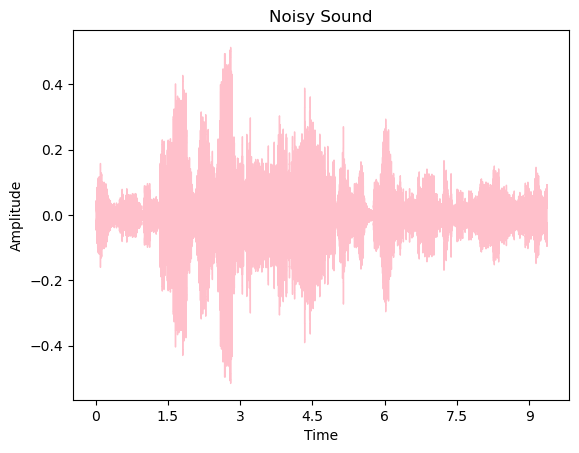

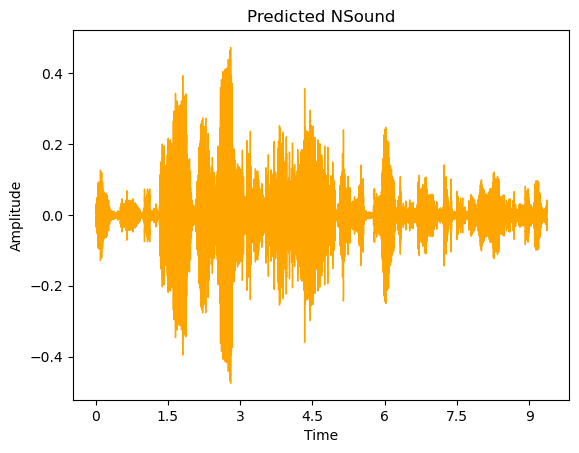

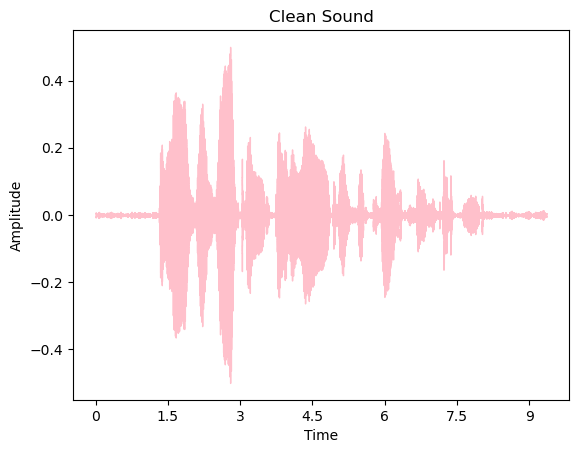

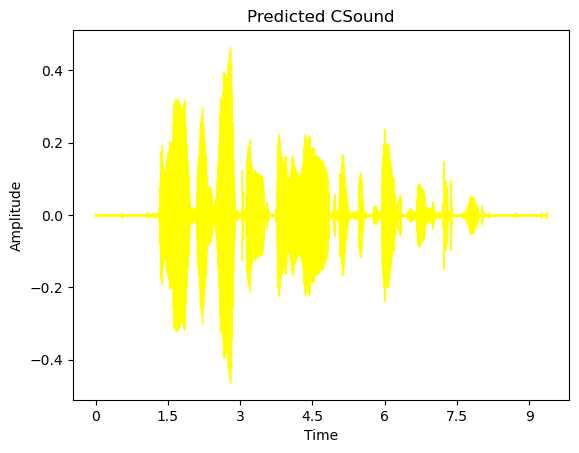

In [289]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Assuming get_audio() and predict_tflite() functions are defined elsewhere

# Specify colors for the waveforms
pink_color = '#FFC0CB'  # Pink color
orange_color = '#FFA500'  # Orange color
yellow_color = '#FFFF00' # Yellow color
green_color = '#008000'  # Green color

# Plot the waveform for the noisy sound with pink color
librosa.display.waveshow(np.squeeze(get_audio(noisy_sounds[4]).numpy(), axis=-1), color=pink_color)
plt.title('Noisy Sound')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Plot the waveform for the predicted sound with orange color
librosa.display.waveshow(predict_tflite(noisy_sounds[4]).numpy(), color=orange_color)
plt.title('Predicted NSound')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


# Plot the waveform for the clean sound with green color
librosa.display.waveshow(np.squeeze(get_audio(clean_sounds[4]).numpy(), axis=-1), color=pink_color)
plt.title('Clean Sound')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Plot the waveform for the predicted sound with orange color
librosa.display.waveshow(predict_tflite(clean_sounds[4]).numpy(), color=yellow_color)
plt.title('Predicted CSound')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()